### So all other attempts at getting the Ising model to work seemingly are just completely noisy. 
Here, is a careful reimplementation of Schroder's algo. I expect no noise WITH NO AVERAGING at very high temps and very low temps. These should be good keystones to hit along the way

In [1]:
#imports 
import numpy as np
import random
import matplotlib.pyplot as plt

In [96]:
def initLattice(latticeSize: int, hot: bool) -> list[list[int]]:
    lattice = np.zeros((latticeSize, latticeSize))
    if hot:
        for i in range(latticeSize):
            for j in range(latticeSize):
                #pick a random spin
                spin = 0
                randomInt = random.randint(0,1)
                if(randomInt == 1):
                    spin = 1
                else:
                    spin = -1
                #set lattice site equal to the random spin    
                lattice[i][j] = spin
    else: #lattice is cold
        for i in range(latticeSize):
            for j in range(latticeSize):
                #set all lattice sites to spin up
                spin = 1
                lattice[i][j] = spin
    
    return lattice

In [248]:
initLattice(10,False)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [463]:
#It turns out some averaging is actually needed. This demonstrates over 1000 trials of a hot start 10x10 lattice, the expected magnetization is zero
#the expected value of magnetization i.e. the average mag at hot temp is 0, but each individual trial can be up to ~ +-20
sumArr = []
for inter in range(1000):
    sum = 0
    lat = initLattice(10,True)
    for i in range(10):
        for j in range(10):
            sum += lat[i][j]
    sumArr.append(sum)

np.average(sumArr)


-0.622

In [465]:
# Calculate change in energy of lattice by flipping a single site (i,j)
def deltaU(i: int, j: int, lattice: list) -> float:
    '''
    This calulation requires considering neighboring sites (first term in Hamiltonian)
    Therefore, we will use periodic boundary conditions (torus)
    I would like to imlement the external field term so you can drive the system to specific states

    E1 = -spin(i,j)*sum(spin(neighbors)),     E2 = spin(i,j)*sum(spin(neighbors))
    Ediff = E2 - E1 = 2spin(i,j)*sum(neighbors) (if spin(i,j) is 1 (up))            <<<<< NO epsilon/J? unclear why, currently just implementing pseudocode exactly as written

    In the mean field approximation E_up = -4J*sum(spin(neighbors))/4) 

    i is vertical, j is horizontal, zero indexed
    '''

    size = len(lattice)
    # If site is in an edge, apply periodic boundary conditions
    if(i == 0):
        top = lattice[size-1,j]
    else:
        top = lattice[i-1][j]
    if(i == size-1):
        bottom = lattice[0][j]
    else:
        bottom = lattice[i+1][j]
    if(j == 0):
        left = lattice[i][size-1]
    else:
        left = lattice[i][j-1]
    if(j == size-1):
        right = lattice[i][0]
    else:
        right = lattice[i][j+1]

    #now calculate the energy difference
    Ediff = 2*lattice[i][j]*(top+bottom+left+right)
    return Ediff

In [1229]:
def Metropolis(lattice, temp, iterations):
    m = []
    for iteration in range(iterations):

        if((iteration % 50 == 0) and (iteration != 0)):
            sum = 0
            for xSite in range(lattice[0].size):
                for ySite in range(lattice[0].size):
                    sum += lattice[xSite][ySite]
            m.append(sum)

        i = random.randint(0,lattice[0].size-1)
        j = random.randint(0,lattice[0].size-1)
        Ediff = deltaU(i,j,lattice)
        #Metropolis to decide whether site should be flipped. Needs to be iterated 100 times??
        if(Ediff <= 0):
            lattice[i][j] = -lattice[i][j] 
        else:
            #now only flip site according to Boltzmann factor
            boltzmannRandom = random.uniform(0,1)
            if(boltzmannRandom < np.exp(-Ediff/temp)): #Ediff must be positive so exponential is between 0 and 1
                lattice[i][j] = -lattice[i][j]

    return m

In [593]:
size = 10
newLattice = initLattice(size,True)
#print(newLattice)
iterationNumber = 100*size*size
Metropolis(newLattice, 2.27, iterationNumber)
#print("\n")
#print(newLattice)


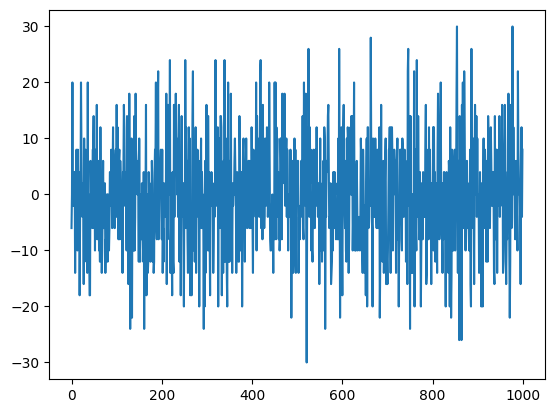

In [861]:
#time series data
sumArr = []
for inter in range(1000):
    sum = 0
    lat = initLattice(10,True)
    for i in range(10):
        for j in range(10):
            sum += lat[i][j]
    sumArr.append(sum)

plt.plot(np.arange(0,len(sumArr)), sumArr)


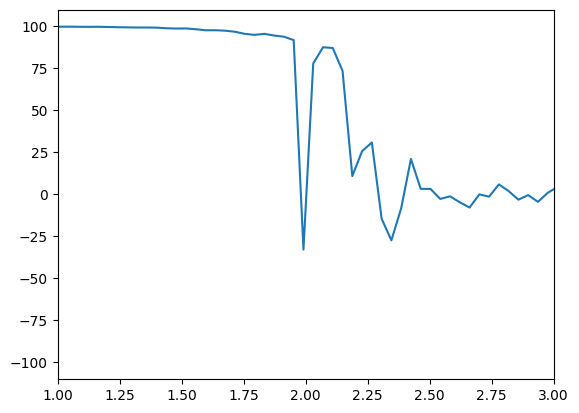

In [1187]:
#reuse averaging code from above with metropolis to make a curve
lat = initLattice(10,False)
avgMags = []
tempRange = np.linspace(0.1,4,100)
for temp in tempRange:
    mTimeSeries = Metropolis(lat, temp, 1000000)
    avg = np.average(mTimeSeries)
    avgMags.append(avg)
    
plt.xlim(1,3)
plt.ylim(-110,110)
plt.plot(tempRange, avgMags) 

Text(0, 0.5, 'Magnetization (100 is max)')

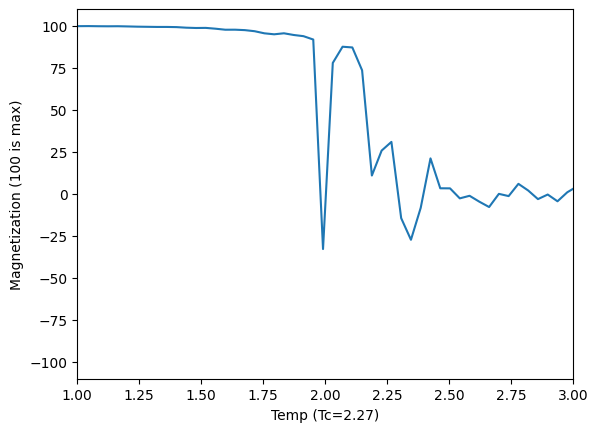

In [1194]:
plt.plot(tempRange, avgMags) 
plt.xlim(1,3)
plt.ylim(-110,110)
plt.xlabel("Temp (Tc=2.27)")
plt.ylabel("Magnetization (100 is max)")
#plt.xlim(0,100)

In [1524]:
#reuse averaging code from above with metropolis to make a curve
lat = initLattice(20,False)
avgMags = []
tempRange = np.linspace(0.1,7,1000)
for temp in tempRange:
    print("T = %s" % temp)
    mTimeSeries = Metropolis(lat, temp, 1000000)
    avg = np.average(mTimeSeries)
    avgMags.append(avg)
    
plt.xlim(0,7)
plt.ylim(-110,20*20+10)
plt.plot(tempRange, avgMags) 
plt.xlabel("Temperature (Tc=2.27)")
plt.ylabel("Magnetization (100 is max)")

T = 0.1
T = 0.1069069069069069
T = 0.11381381381381382


Text(0, 0.5, 'Magnetization (100 is max)')

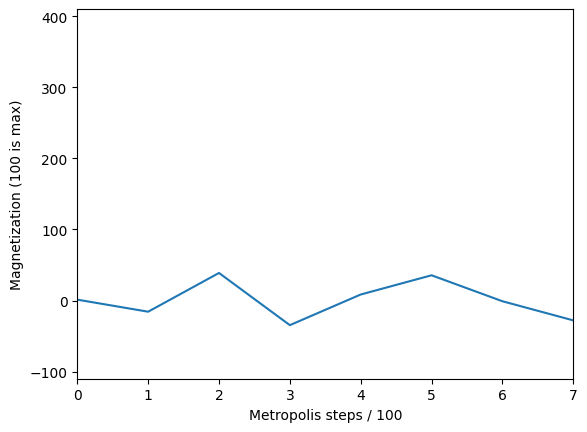

In [1523]:
#reuse averaging code from above with metropolis to make a curve
lat = initLattice(20,False)
avgMags = []
tempRange = np.arange(0,100)
for temp in tempRange:
    mTimeSeries = Metropolis(lat, 3, 100000)
    avg = np.average(mTimeSeries)
    avgMags.append(avg)
    
plt.xlim(0,7)
plt.ylim(-110,20*20+10)
plt.plot(tempRange, avgMags) 
plt.xlabel("Metropolis steps / 100")
plt.ylabel("Magnetization (100 is max)")